# Credit Card Fraud with Machine Learning

The aim of this project is to build a classifier so that we can detect credit card fraudulent transaction. The dataset is obtained from: https://www.kaggle.com/mlg-ulb/creditcardfraud.

In [102]:
import os
import sys
import pandas
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

input_file = "./creditcard.csv"

# Data Exploration

The dataset consists of credit card transactions that features (V1, V2... Vx) are the product of PCA analysis. The only features that are non-PCA are **Time, Amount, Class**.

- Time: Seconds elapsed between each transaction and first transaction
- Class: Type of transaction (1 is fraud, 0 is valid)
- Amount: Transaction Amount

The purpose of this section is to understand the data so that we know how to proceed to the next step.

In [107]:
df = pandas.read_csv(input_file, header=0)

In [7]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.isnull().values.any() # Nice, no missing value in this dataset

False

In [16]:
df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [31]:
df["Time"].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

## How many transactions are labeled as fraud?

This seems like an imbalance dataset. With 492 fraud and 284315 valid transaction. This is highly imbalanced...

In [23]:
pd.value_counts(df["Class"])

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:>

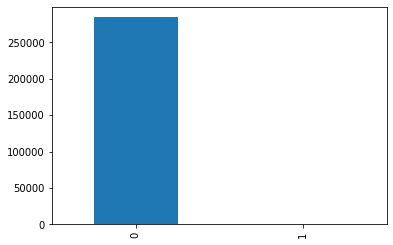

In [34]:
pd.value_counts(df["Class"]).plot.bar()

## What is the distribution of the other "known" features?

The distribution of the graphs show the following:

1) Amount is skewed --> potentially be biased?

2) Time is less skewed.

If the sample is unbalanced, this may cause overfitting. The model might assume for the most cases when the sample is heavily skewed on another end (mostly valid).

<AxesSubplot:ylabel='Frequency'>

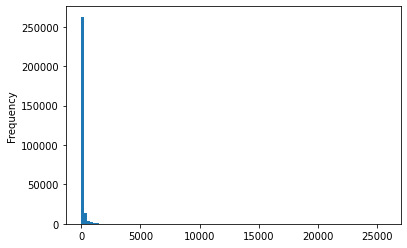

In [45]:
df["Amount"].sort_values().plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

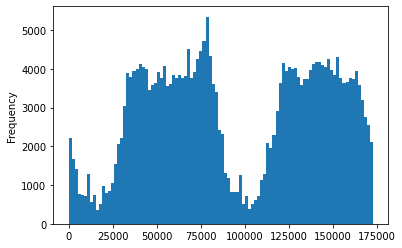

In [44]:
df["Time"].sort_values().plot.hist(bins=100)

## How are the amount distributed in the "fraud" cases?

<AxesSubplot:ylabel='Frequency'>

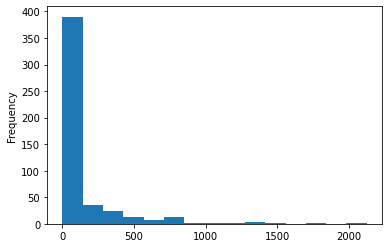

In [50]:
df[df["Class"] == 1]["Amount"].sort_values().plot.hist(bins=15)

## How are the amount distributed in the non-fraud cases?

<AxesSubplot:ylabel='Frequency'>

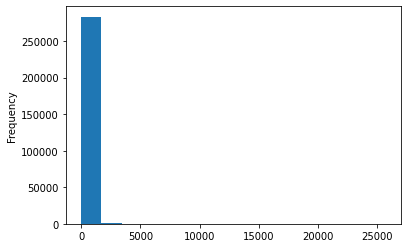

In [51]:
df[df["Class"] == 0]["Amount"].sort_values().plot.hist(bins=15)

# Dealing with Imbalanced Dataset

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

- Resample the training set #1: Under-sampling (reduces the size of abundant class. Quantity of data is sufficient)
- Resample the training set #2: Over-sampling (increase the size of the rare samples)

In our case, I think it would be possible for us to use one of these techniques to resample the training set. I can first try to reduce the size of abundant class... so i will reduce the valid transaction to 492 samples so it's balance

In [108]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [109]:
resamples = df.sample(frac=1) # resample a fraction

In [110]:
fraud = resamples.loc[df["Class"] == 1] # take all the fraud transaction
non_fraud = resamples.loc[df["Class"] == 0][:492] # take 492 the non-fraud transaction

In [111]:
new_df = pd.concat([fraud, non_fraud])

<AxesSubplot:>

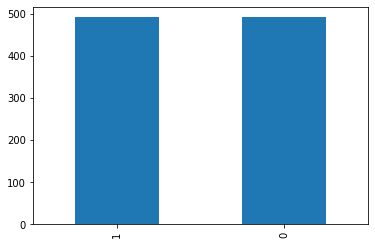

In [112]:
pd.value_counts(new_df["Class"]).plot.bar()

# Transform the Amount/Time

Since "Amount" and "Time" are not transformed, we will not be able to run any other stuffs beyond this.

In [113]:
new_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
96789,65936.0,-3.593476,0.781442,-1.822448,0.605761,-1.194656,-0.517195,-1.722523,0.128890,0.014963,...,0.351792,0.391249,-0.252875,-0.498042,0.010172,0.909929,-1.478767,0.722673,101.50,1
274475,166028.0,-0.956390,2.361594,-3.171195,1.970759,0.474761,-1.902598,-0.055178,0.277831,-1.745854,...,0.473211,0.719400,0.122458,-0.255650,-0.619259,-0.484280,0.683535,0.443299,39.90,1
219025,141565.0,0.114965,0.766762,-0.494132,0.116772,0.868169,-0.477982,0.438496,0.063073,-0.186207,...,-0.284413,-0.706865,0.131405,0.600742,-0.604264,0.262938,0.099145,0.010810,4.49,1
44223,41851.0,-19.139733,9.286847,-20.134992,7.818673,-15.652208,-1.668348,-21.340478,0.641900,-8.550110,...,-2.182692,0.520543,-0.760556,0.662767,-0.948454,0.121796,-3.381843,-1.256524,139.90,1
88307,62080.0,-1.599457,2.607720,-2.987193,3.064156,-2.497914,-0.541103,-2.277786,1.268166,-1.997331,...,0.662933,0.184087,-0.089452,-0.506000,-0.062259,-0.052714,0.322854,0.135268,180.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259294,159050.0,1.525174,-2.141343,0.059417,-0.580808,-2.151077,-0.294340,-1.168633,-0.058361,0.468646,...,0.009558,0.047869,0.091432,0.124362,-0.898034,1.210920,-0.068153,0.013915,304.90,0
248693,154052.0,1.994708,0.202986,-1.699665,1.197022,0.704945,-0.616030,0.596291,-0.296859,-0.151811,...,0.093444,0.484723,-0.070764,-0.368684,0.494809,-0.489933,-0.015359,-0.072563,16.23,0
141397,84288.0,-0.994435,0.189321,1.908873,-2.499186,0.237313,0.358123,-0.066577,0.368938,1.336734,...,0.229053,0.793701,-0.502777,-1.303073,0.726855,-0.542041,0.360094,0.129217,19.99,0
272627,165187.0,-1.302948,0.864295,-0.918924,-0.302191,-0.240856,-1.162195,0.435364,0.644166,0.093389,...,-0.132308,-0.606040,-0.140184,-0.156120,0.167999,-0.086882,-0.299184,-0.254410,110.14,0


In [121]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

new_df["scaled_amount"] = scaler.fit_transform(new_df["Amount"].values.reshape(-1, 1))
new_df["scaled_time"] = scaler.fit_transform(new_df["Time"].values.reshape(-1, 1))

scaled_df = new_df.drop(["Time", "Amount"], axis=1)

In [119]:
scaled_df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
96789,-3.593476,0.781442,-1.822448,0.605761,-1.194656,-0.517195,-1.722523,0.128890,0.014963,-2.856117,...,0.391249,-0.252875,-0.498042,0.010172,0.909929,-1.478767,0.722673,1,-0.028714,-0.468989
274475,-0.956390,2.361594,-3.171195,1.970759,0.474761,-1.902598,-0.055178,0.277831,-1.745854,-2.516628,...,0.719400,0.122458,-0.255650,-0.619259,-0.484280,0.683535,0.443299,1,-0.295080,1.601203
219025,0.114965,0.766762,-0.494132,0.116772,0.868169,-0.477982,0.438496,0.063073,-0.186207,-0.159325,...,-0.706865,0.131405,0.600742,-0.604264,0.262938,0.099145,0.010810,1,-0.448197,1.095238
44223,-19.139733,9.286847,-20.134992,7.818673,-15.652208,-1.668348,-21.340478,0.641900,-8.550110,-16.649628,...,0.520543,-0.760556,0.662767,-0.948454,0.121796,-3.381843,-1.256524,1,0.137332,-0.967137
88307,-1.599457,2.607720,-2.987193,3.064156,-2.497914,-0.541103,-2.277786,1.268166,-1.997331,-3.834775,...,0.184087,-0.089452,-0.506000,-0.062259,-0.052714,0.322854,0.135268,1,0.310729,-0.548743
48094,-1.278138,0.716242,-1.143279,0.217805,-1.293890,-1.168952,-2.564182,0.204532,-1.611155,-1.250286,...,0.470427,-0.126261,-0.126644,-0.661908,-0.349793,0.454851,0.137843,1,-0.359942,-0.933155
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,0.569874,-1.740450
9035,-2.589617,7.016714,-13.705407,10.343228,-2.954461,-3.055116,-9.301289,3.349573,-5.654212,-11.853867,...,0.333998,0.287659,-1.186406,-0.690273,0.631704,1.934221,0.789687,1,-0.463289,-1.572194
145800,-0.419820,-1.155978,-2.092516,2.786750,0.736297,-0.167292,1.600027,-0.117427,-0.796954,-0.133950,...,0.533517,1.284645,0.516131,-0.602941,-0.305024,-0.021363,0.129096,1,1.483734,-0.029147
135718,-0.885254,1.790649,-0.945149,3.853433,-1.543510,0.188582,-2.988383,1.344059,-2.294535,-1.886176,...,0.550802,-0.034882,-0.567608,-0.528318,0.258782,0.506893,0.176736,1,-0.434879,-0.149728


# Correlation Matrix

See if any features give a very strong influence to the fraud/valid transaction

<AxesSubplot:>

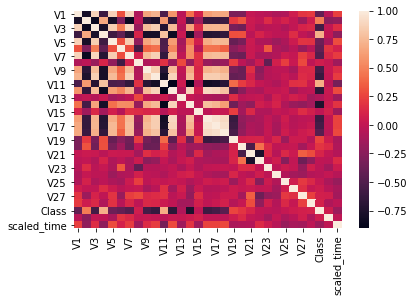

In [122]:
corr = scaled_df.corr()
sns.heatmap(corr)

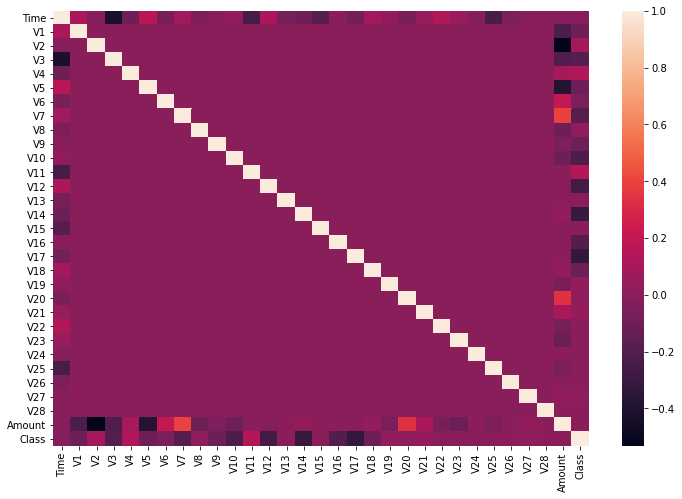

In [137]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

corr = df.corr()
sns.heatmap(corr, annot_kws={'size':20}, ax=ax)
plt.show()

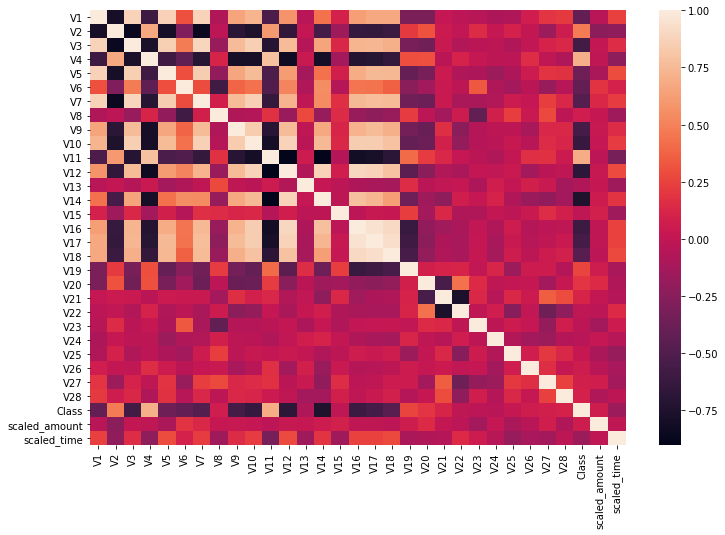

In [136]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

corr = scaled_df.corr()
sns.heatmap(corr, annot_kws={'size':20}, ax=ax)
plt.show()

# Training the Model

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

X = scaled_df.drop("Class", axis=1)
y = scaled_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [171]:
print("Number of training set samples: {0}".format(len(X_train)))
print("Number of testing set samples: {0}".format(len(X_test)))

Number of training set samples: 787
Number of testing set samples: 197


## LogisticRegression

In [168]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train) # X is the training sample, y is the ground-truth of the training sample
training_score = cross_val_score(classifier, X_train, y_train, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (training_score.mean(), training_score.std() * 2))

Accuracy: 0.94 (+/- 0.01)


In [163]:
from sklearn.metrics import f1_score

y_pred = classifier.predict(X_test)
score = f1_score(y_pred, y_test)

print(score)

0.9595959595959597


## Confusion Matrix

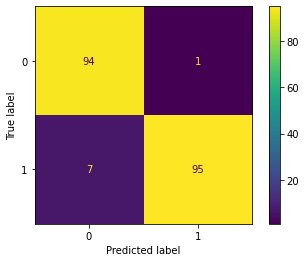

In [167]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classifier, X_test, y_test)
plt.show()